In [41]:
import osmnx
import geopandas as gpd
import momepy
import matplotlib.pyplot as plt
import contextily as cx

from matplotlib_scalebar.scalebar import ScaleBar
from geemap import cartoee


### Download data
Our study area for this example notebook will be the centre of Paris. below, a map with the study area can be found.
For this area, we will download some data from OpenStreetMap, specifically:

- Streets
- Buildings

In [39]:
# load study area
bb = gpd.read_parquet('./data/bb.parquet')

c:\Users\b9066009\Anaconda3\envs\geo_env\lib\site-packages\matplotlib_scalebar\scalebar.py:308: DeprecationWarning: The height_fraction argument was deprecated. Use width_fraction instead.
  warnings.warn(


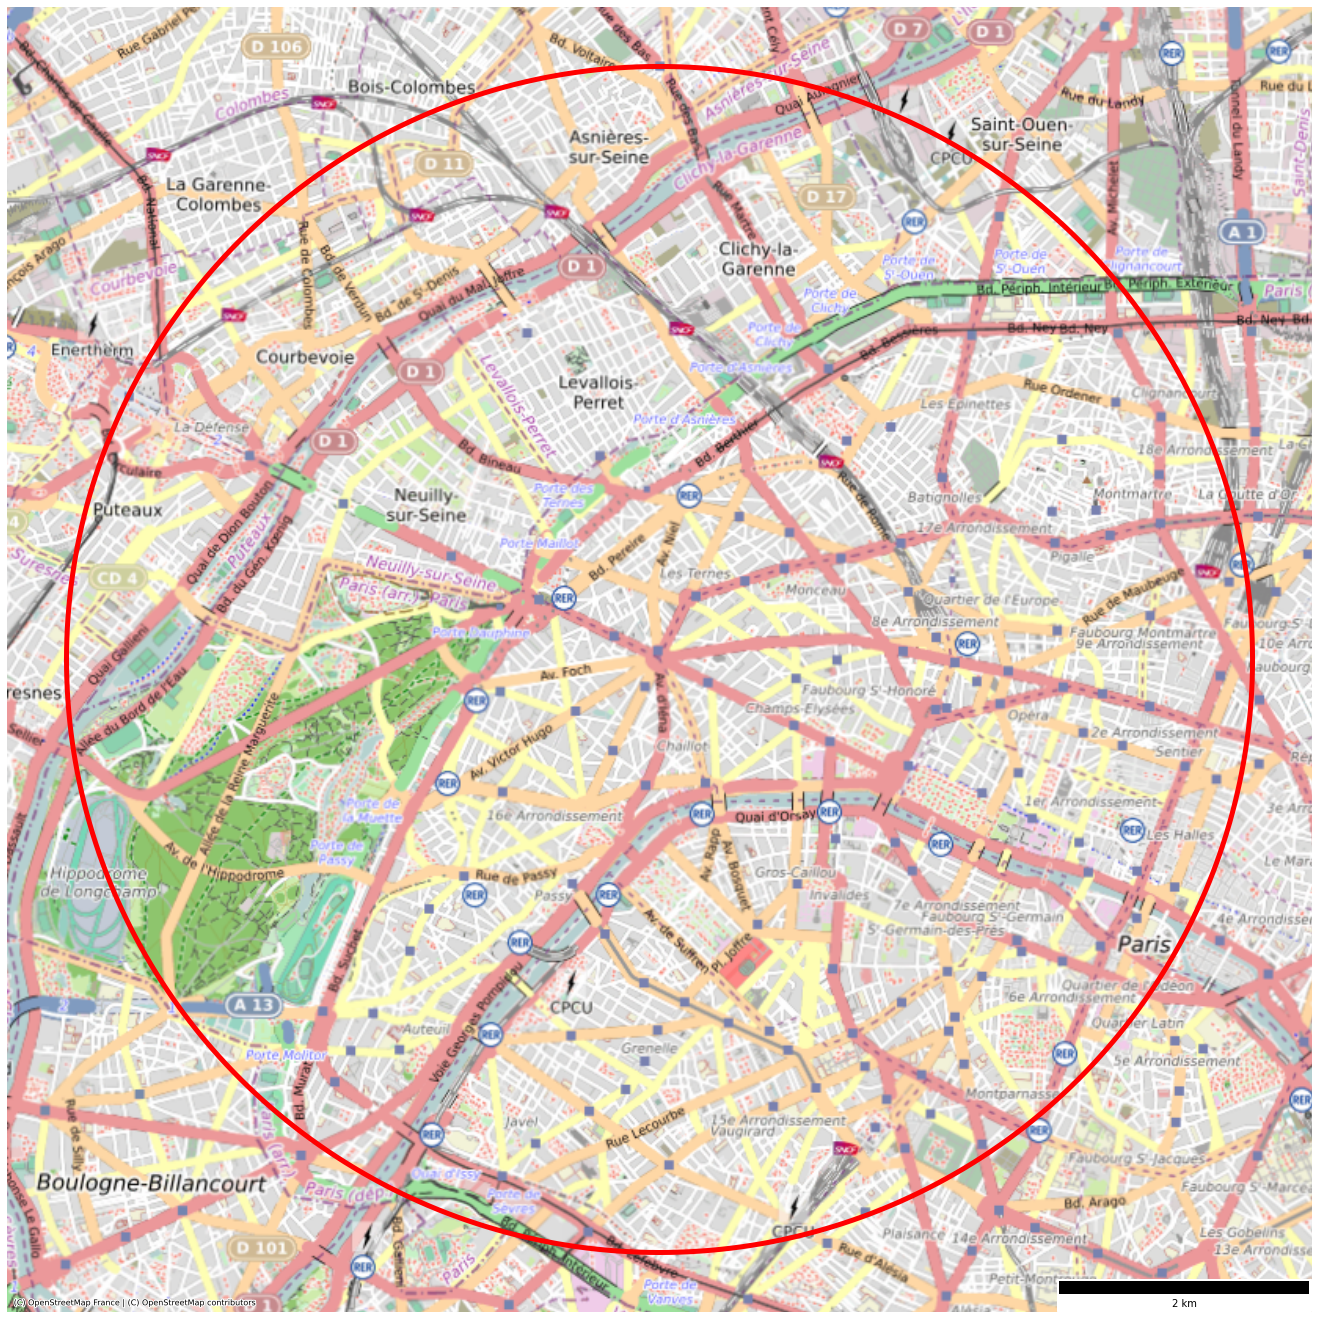

In [107]:
f, ax = plt.subplots(1, figsize=(24,24))
ax = bb.boundary.plot(ax = ax, color = 'red', linewidth = 5)
cx.add_basemap(ax,
               crs=bb.crs.to_string(),
               source = cx.providers.OpenStreetMap.France)

ax.set_axis_off()

scalebar = ScaleBar(dx=1,
                    location=(4),
                    height_fraction=0.01
                    )
ax.add_artist(scalebar)
plt.savefig('./figures/study_area.png', bbox_inches='tight')

Now that the study area is defined, we can start downloading data form OSM.

We will generate a buffer around our study area limits, in order to account for accessibility in the border of the boundary.

In [109]:
bb_buffer = bb.buffer(2000)

TypeError: 'int' object is not iterable

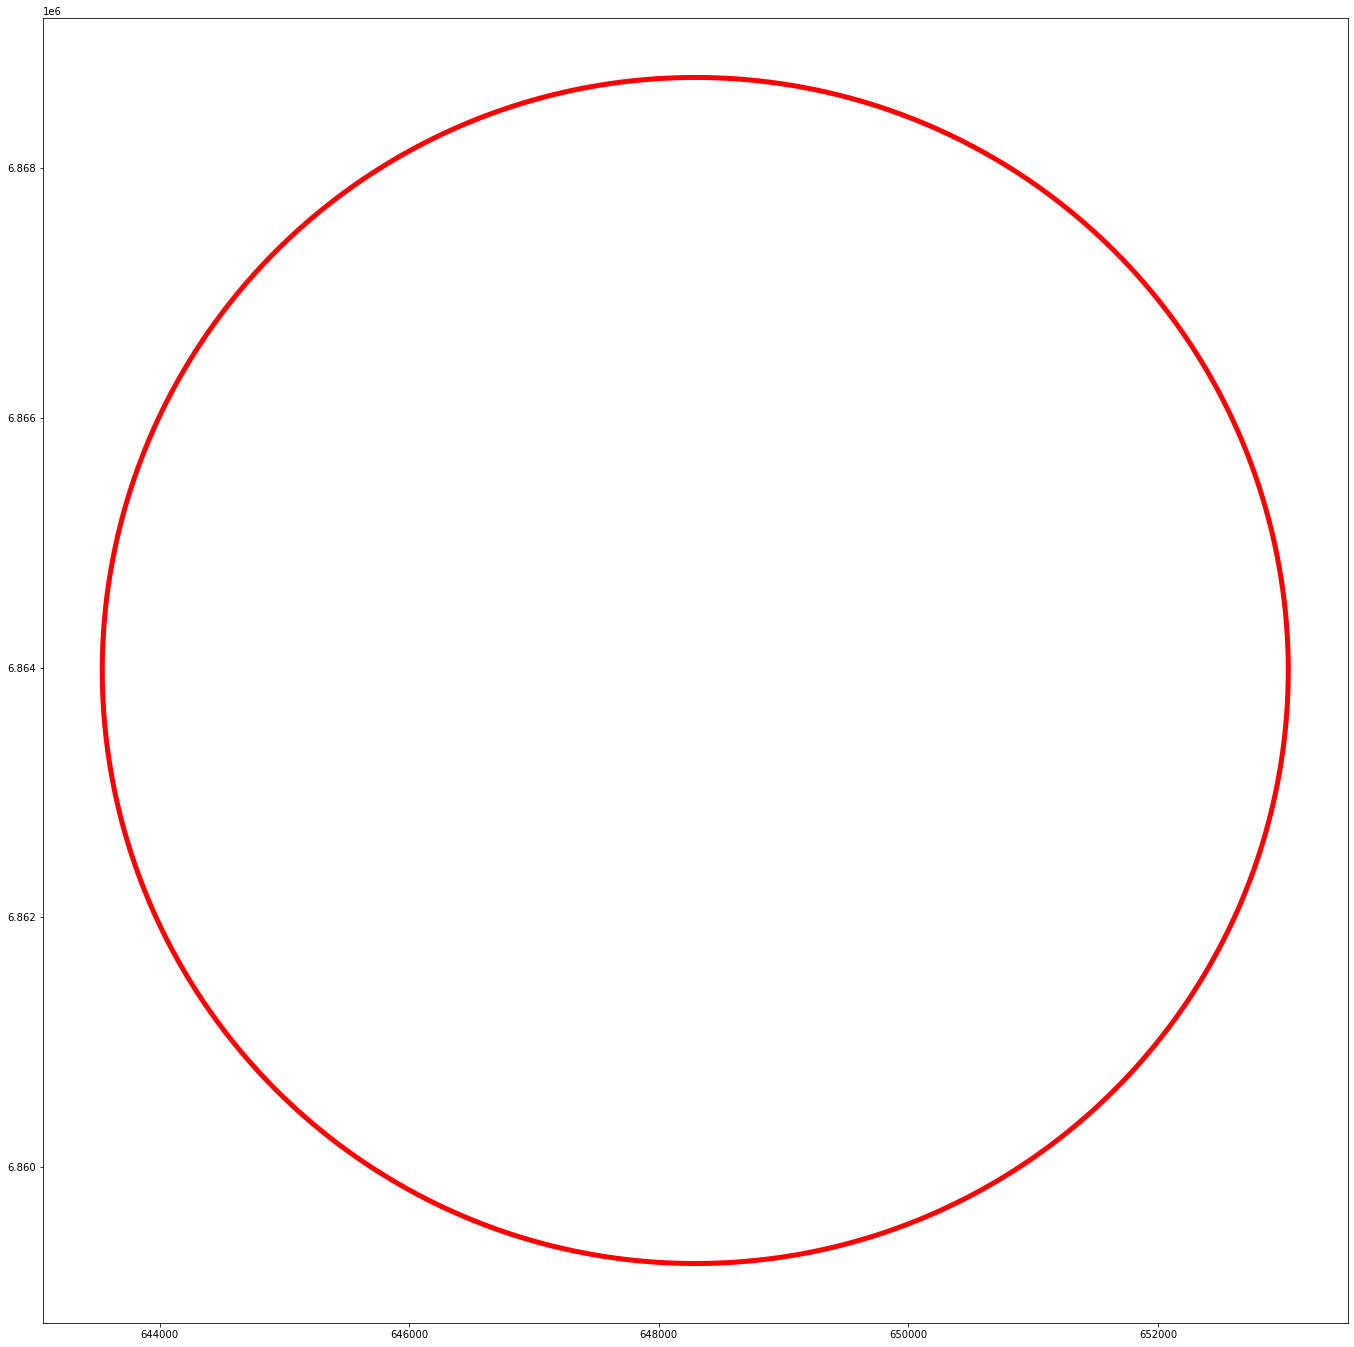

In [112]:
f, ax = plt.subplots(1, figsize=(24,24))
ax = bb.boundary.plot(ax = ax, color = 'red', linewidth = 5)
bb_buffer.boundary.plot(ax = ax, linewidth = 5)
cx.add_basemap(ax,
               crs=bb.crs.to_string(),
               source = cx.providers.OpenStreetMap.France)

ax.set_axis_off()

scalebar = ScaleBar(dx=1,
                    location=(4),
                    height_fraction=0.01
                    )
ax.add_artist(scalebar)

In [2]:
G = osmnx.graph_from_point((48.87448833798131, 2.297089117382608), dist = 5000, network_type= 'walk', ) # streets

In [3]:
buildings = osmnx.geometries_from_point((48.87448833798131, 2.297089117382608), dist = 5000, tags={'building':True}) # buildings

c:\Users\b9066009\Anaconda3\envs\geo_env\lib\site-packages\osmnx\geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
c:\Users\b9066009\Anaconda3\envs\geo_env\lib\site-packages\osmnx\geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
c:\Users\b9066009\Anaconda3\envs\geo_env\lib\site-packages\osmnx\geometries.py:872: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geo

### Data cleaning
The data we just downloaded is not yet ready for processing. It requires a bit of cleaning.

In [4]:
# set local crs
local_crs = 2154

In [5]:
# clean buildings
buildings = buildings.reset_index()[['geometry']] # keep only geometry and reset index
buildings = buildings[buildings.geom_type == "Polygon"].reset_index(drop=True)# keep polygons only
buildings['uID'] = range(len(buildings))  # add a unique ID for each building
buildings = buildings[["geometry"]].to_crs(local_crs) # set geometry

In [6]:
buildings.to_parquet('./data/buildings.parquet')

C:\Users\b9066009\AppData\Local\Temp\ipykernel_14500\707751399.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  buildings.to_parquet('./data/buildings.parquet')


In [7]:
# clean streets
G = osmnx.projection.project_graph(G, to_crs=local_crs) # project graph
streets = osmnx.graph_to_gdfs(G, 
                              nodes=False, 
                              edges=True,
                              node_geometry=False,
                              fill_edge_geometry=True)

In [8]:
streets = momepy.remove_false_nodes(streets)
streets = streets[["geometry"]]
streets["nID"] = range(len(streets))

In [9]:
streets.to_parquet('./data/streets.parquet')

C:\Users\b9066009\AppData\Local\Temp\ipykernel_14500\1592874957.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  streets.to_parquet('./data/streets.parquet')


### Plot outputs

c:\Users\b9066009\Anaconda3\envs\geo_env\lib\site-packages\matplotlib_scalebar\scalebar.py:308: DeprecationWarning: The height_fraction argument was deprecated. Use width_fraction instead.
  warnings.warn(


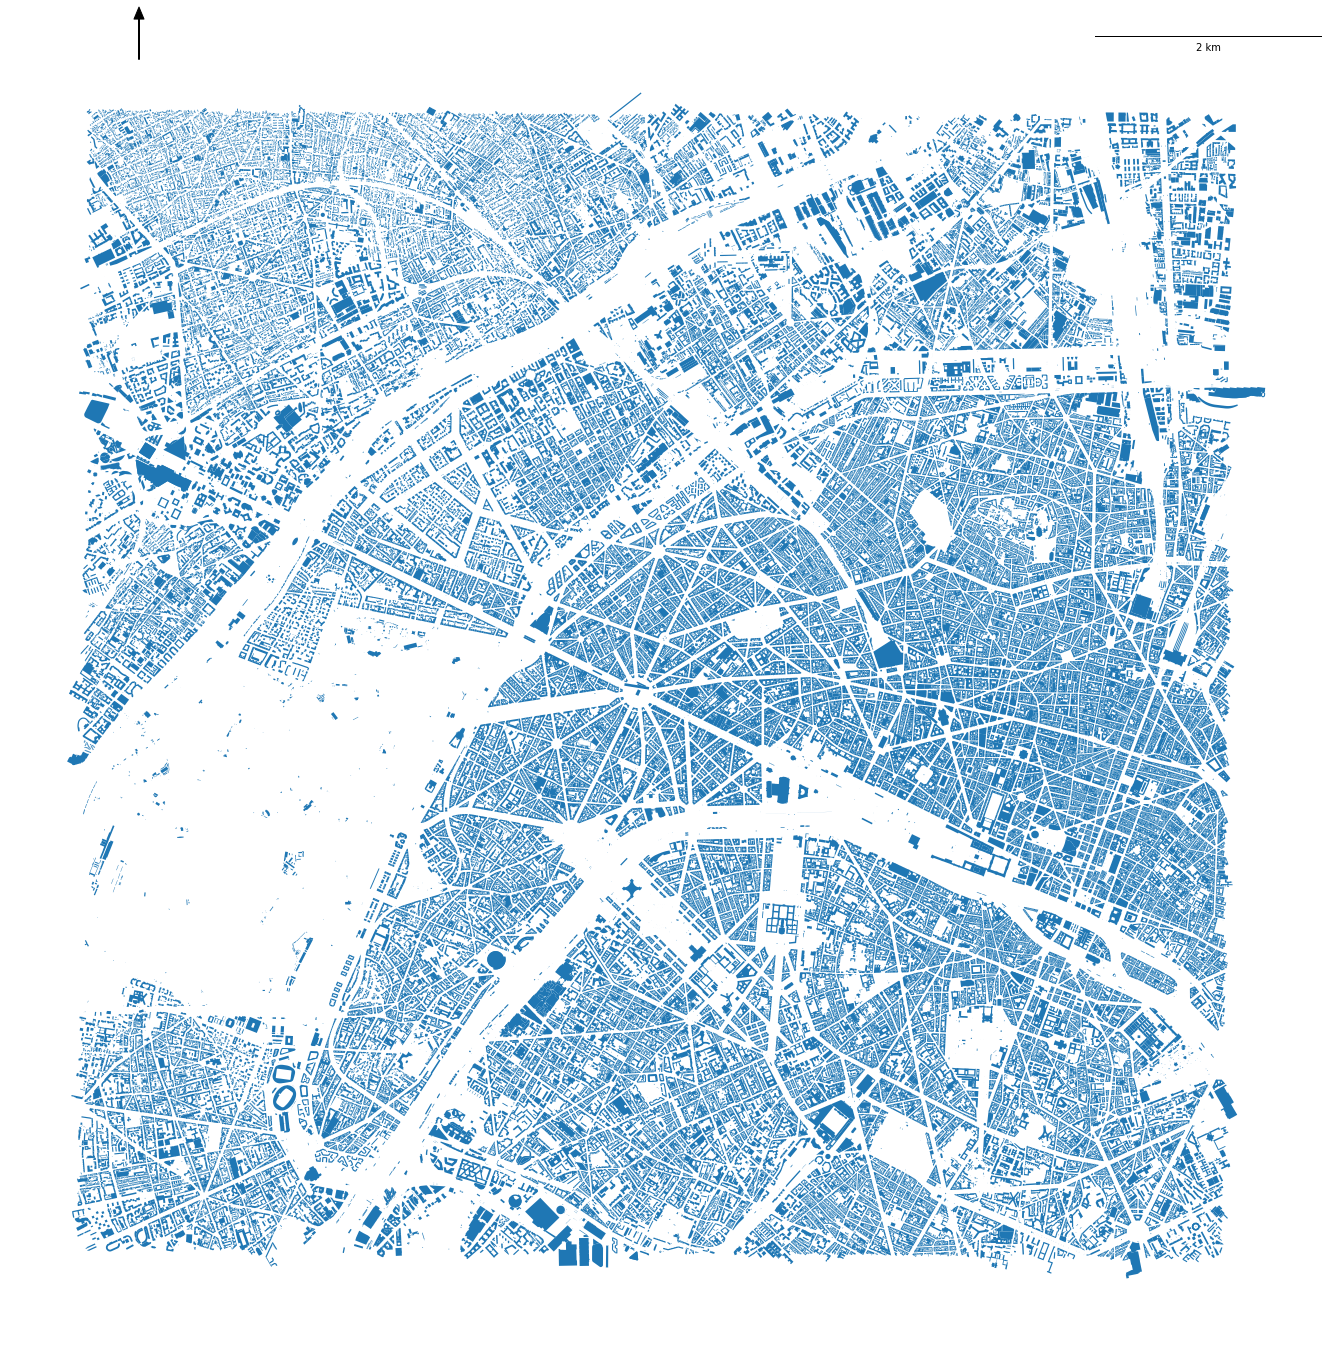

In [12]:
f, ax = plt.subplots(1, figsize=(24,24))
ax = buildings.plot(ax = ax)
ax.set_axis_off()

scalebar = ScaleBar(dx=1,
                    location=1,
                    height_fraction=0.001
                    )
ax.add_artist(scalebar)

cartoee.add_north_arrow(
    ax, text='', xy=(0.1,1.02), arrow_length=0.04, arrow_color="black", width = 1, headwidth = 10)

plt.savefig('./figures/buildings.png', bbox_inches='tight')

c:\Users\b9066009\Anaconda3\envs\geo_env\lib\site-packages\matplotlib_scalebar\scalebar.py:308: DeprecationWarning: The height_fraction argument was deprecated. Use width_fraction instead.
  warnings.warn(


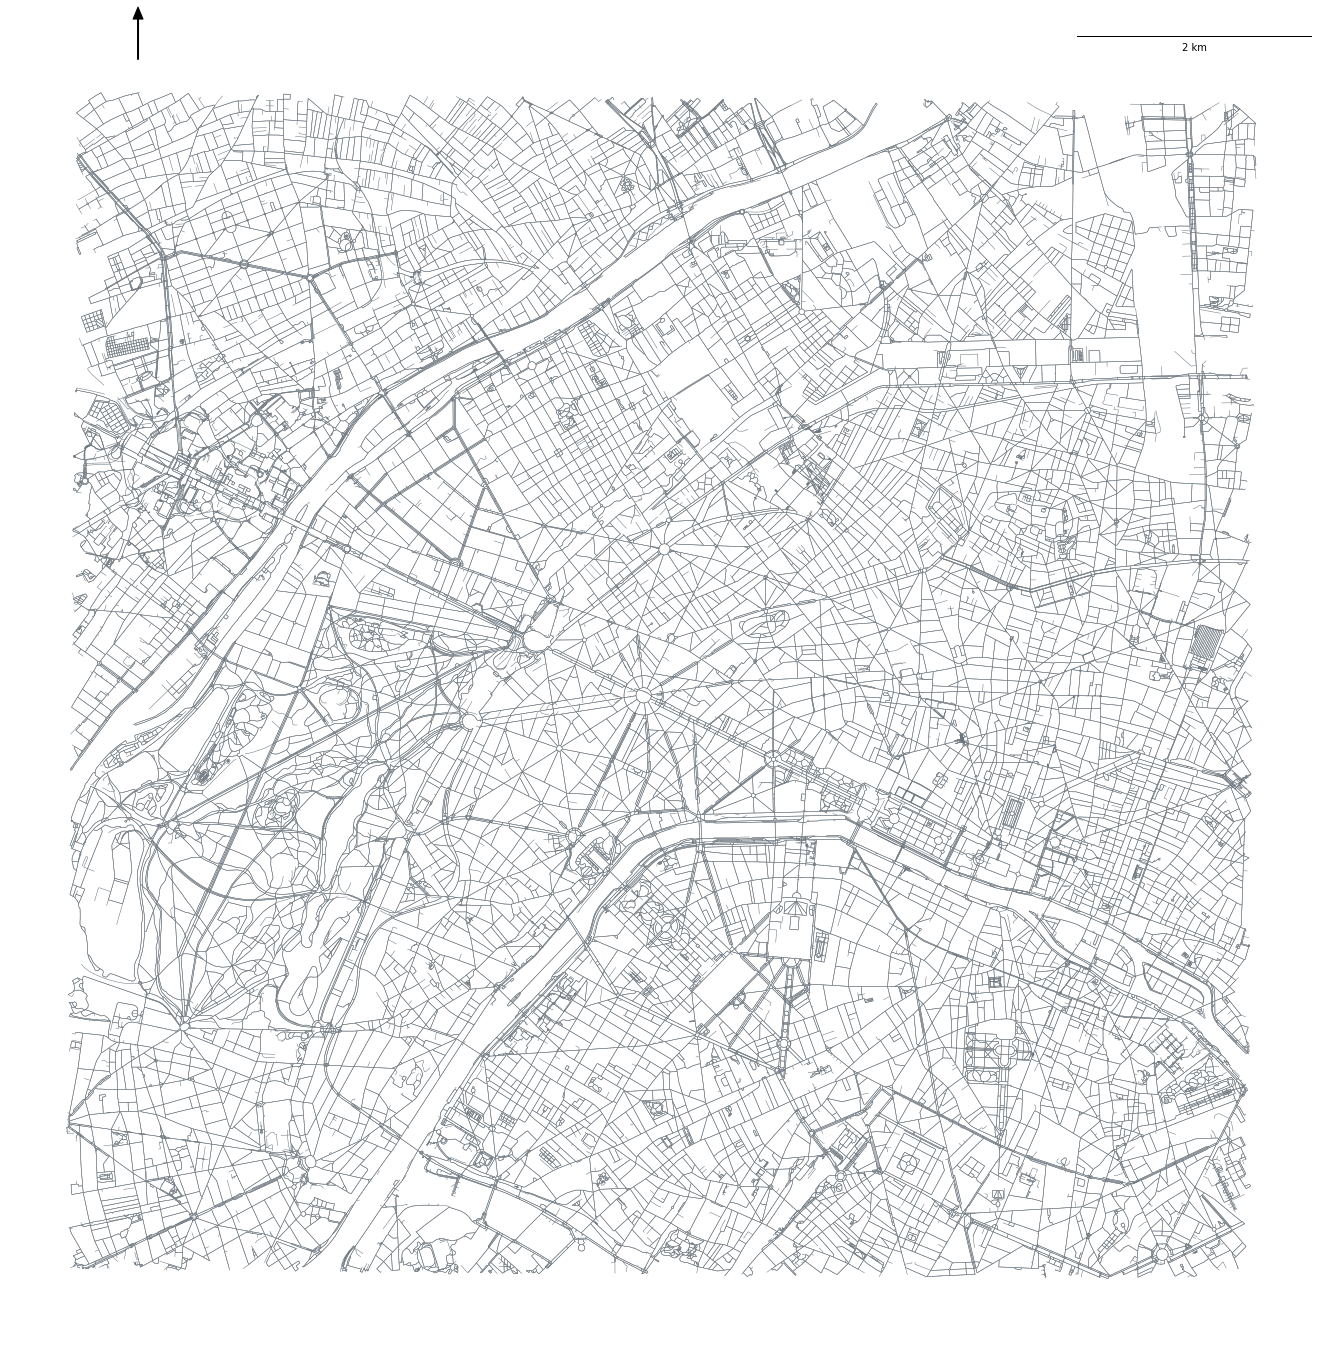

In [15]:
f, ax = plt.subplots(1, figsize=(24,24))
ax = streets.plot(ax = ax, color = '#6c757d', linewidth = 0.5)
ax.set_axis_off()

scalebar = ScaleBar(dx=1,
                    location=1,
                    height_fraction=0.001
                    )
ax.add_artist(scalebar)

cartoee.add_north_arrow(
    ax, text='', xy=(0.1,1.02), arrow_length=0.04, arrow_color="black", width = 1, headwidth = 10)

plt.savefig('./figures/streets.png', bbox_inches='tight')

In [72]:
 def blank_axes(ax):
        """
        blank_axes:  blank the extraneous spines and tick marks for an axes

        Input:
        ax:  a matplotlib Axes object

        Output: None
        """


        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_ticks_position('none')
        ax.tick_params(labelbottom='off', labeltop='off', labelleft='off', labelright='off' ,\
                        bottom='off', top='off', left='off', right='off' )
    #end blank_axes

NameError: name 'datetime' is not defined

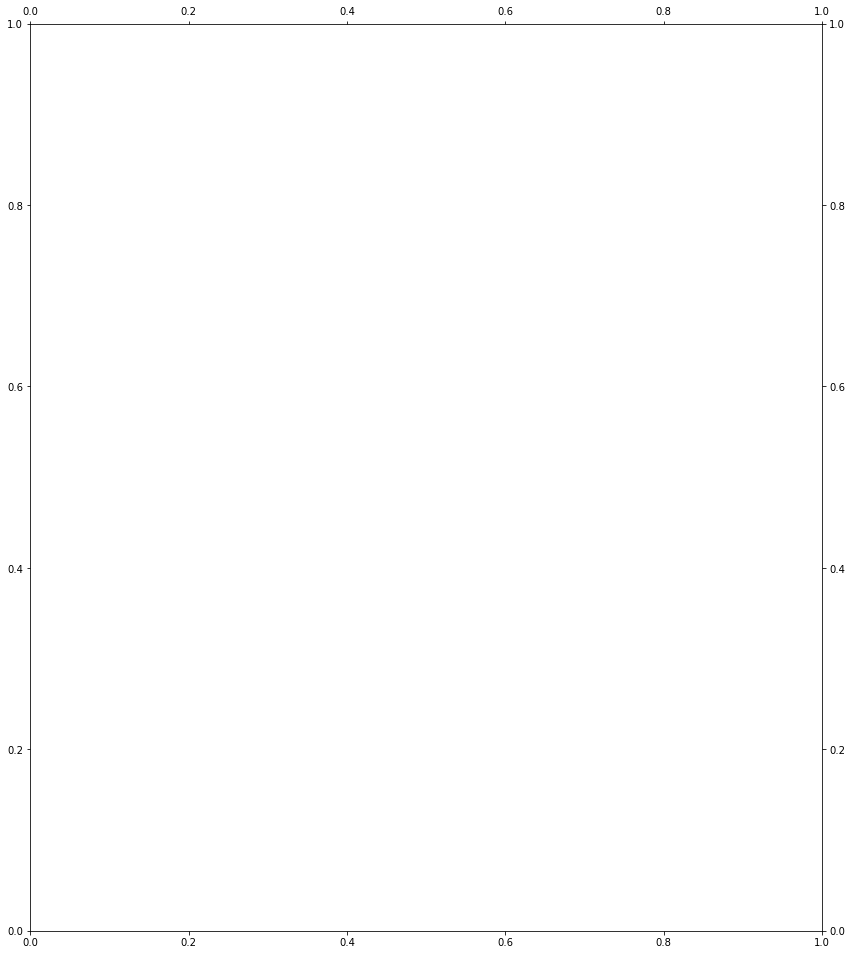

In [73]:
    fig = plt.figure(figsize=(10,12))

    # ------------------------------- Surrounding frame ------------------------------
    # set up frame full height, full width of figure, this must be called first

    left = -0.05
    bottom = -0.05
    width = 1.1
    height = 1.05
    rect = [left,bottom,width,height]
    ax3 = plt.axes(rect)

    # turn on the spines we want, ie just the surrounding frame
    blank_axes(ax3)
    ax3.spines['right'].set_visible(True)
    ax3.spines['top'].set_visible(True)
    ax3.spines['bottom'].set_visible(True)
    ax3.spines['left'].set_visible(True)

    ax3.text(0.01,0.01,'© Don Cameron, 2017: net-analysis.com. '+
             'Map generated at '+datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") + ' from ' +theNotebook, fontsize=8)